In [215]:
import sympy as sym 
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm

In [216]:
class Swizzle:
    
  BitAnd = sym.Function('BitAnd')
  BitOr  = sym.Function('BitOr')
  BitXor = sym.Function('BitXor')
  RShift = sym.Function('RShift')
  LShift = sym.Function('LShift')
  BitNot = sym.Function('BitNot')
  Max = sym.Max
  Min = sym.Min

  def __init__(self, m_base: int, b_bits: int, s_shift: int, N_elems: int):
      
    assert m_base >= 0 
    assert b_bits >= 0 
    assert abs(s_shift) >= b_bits 
    self.N_elems = N_elems
    
    self.m_base = sym.Integer(m_base)
    self.b_bits = sym.Integer(b_bits)
    self.s_shift = sym.Integer(s_shift)
    
    self.b = sym.Symbol('b', integer=True) 
    self.m = sym.Symbol('m', integer=True)
    self.s = sym.Symbol('s', integer=True)
    self.x = sym.Symbol('x', integer=True)

    LShift, BitAnd, BitOr = Swizzle.LShift, Swizzle.BitAnd, Swizzle.BitOr
    BitXor, RShift = Swizzle.BitXor, Swizzle.RShift
    Max, Min = Swizzle.Max, Swizzle.Min

    one = sym.Integer(1) 
    zero = sym.Integer(0)

    base_mask = (LShift(one, self.b)) - 1
    src_shift = self.m + Max(zero, self.s)
    dst_shift = self.m - Min(zero, self.s)
    
    src_mask = LShift(base_mask, src_shift) 
    dst_mask = LShift(base_mask, dst_shift)
    
    bits_to_move = BitAnd(self.x, src_mask)
    
    self.swizzle_mask = BitOr(src_mask, dst_mask)
    
    expr_pos_s = BitXor(self.x, RShift(bits_to_move, self.s))
    expr_neg_s = BitXor(self.x, LShift(bits_to_move, -self.s))

    self.swizzle_map_sym = sym.Piecewise(
        (expr_pos_s, self.s >= 0),
        (expr_neg_s, True)
    )
    self.swizzle_map = self._substitute(self.swizzle_map_sym, (self.m_base, self.b_bits, self.s_shift), (self.m, self.b, self.s))
    self.realized_swizzle_map = "un_realized"
    

  def __repr__(self):
    return (
        f"Swizzle(\n"
        f"  symbols = ({self.b}, {self.m}, {self.s}, {self.x}),\n"
        f"  mask    = {self.swizzle_mask},\n"
        f"  map     = {self.swizzle_map_sym}\n"
        f")"
    )
      
  def _get_realization_map(self):
    import numpy as np
    return {
        'BitAnd': np.bitwise_and,
        'BitOr':  np.bitwise_or,
        'BitXor': np.bitwise_xor,
        'RShift': np.right_shift,
        'LShift': np.left_shift,
        'BitNot': np.invert,
        'Max':    np.maximum,
        'Min':    np.minimum
    }
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self):
    ops = self._get_realization_map()
    
    func_lamb = sym.lambdify(
            self.x, 
            self.swizzle_map, 
            modules=['numpy', ops]
        )
    arr = np.arange(self.N_elems)
    self.realized_swizzle_map = func_lamb(arr)

In [217]:
class Layout: 
  def __init__ (self, shape: Tuple[int,...], stride: Tuple[int,...], 
                kind: str):
    
    assert len(shape) == len(stride) 
    self.m = len(shape)
    self.shape_int = shape
    self.stride_int = stride
    self.shape = tuple([sym.Integer(shape[i]) for i in range(self.m)])
    self.stride = tuple([sym.Integer(stride[i]) for i in range(self.m)])
    self.S = tuple([sym.Symbol(f"S_{str(i)}") for i in range(self.m)])
    self.S_S = [sym.Integer(1)]*self.m
    self.D = tuple([sym.Symbol(f"D_{str(i)}") for i in range(self.m)])
    self.I = sym.Symbol("x")
    self.N_elems = 1 
    for i in range(self.m): 
      self.N_elems *= shape[i]
      
    
    for i in range(1,self.m): 
      self.S_S[i] = self.S[i-1]*self.S_S[i-1]
      
    self.S_S = tuple(self.S_S)  
    

    self.fan_out = [0]*self.m 
    for i in range(self.m): 
      self.fan_out[i] = (self.I // self.S_S[i]) % self.S[i]
    
    self.fan_out = tuple(self.fan_out)
    
    self.fan_in = sym.Integer(0) 
    self.fan_out_sym = tuple([sym.Symbol(f"y_{str(i)}") for i in range(self.m)])
    for i in range(self.m):
      self.fan_in += self.D[i]*self.fan_out_sym[i]
      
    self.layout_sym = self._substitute(self.fan_in, self.fan_out, self.fan_out_sym)
    self.layout = self._substitute(self.layout_sym, self.shape, self.S)
    self.layout = self._substitute(self.layout, self.stride, self.D)
    self.realized_layout = "un_realized"
    
    
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self): 
    one_d_domain = np.arange(self.N_elems) 
    layout_lambda = sym.lambdify([self.I], self.layout, "numpy")
    self.realized_layout = layout_lambda(one_d_domain).astype(int)
    

In [218]:
def expand(layout, n_elems_per_vector, n_bytes_per_elem): 
  g = n_elems_per_vector * n_bytes_per_elem
  layout_to_bytes = np.zeros((np.size(layout),g)).astype(int)
  for i in range(g):
    layout_to_bytes[:,i] = g*layout + i 
    
  return layout_to_bytes.flatten()

In [333]:
def make_swizzle(layout, n_elems_per_vector, n_bytes_per_elem,
                 b_bits, m_base, s_shift):

    layout.realize()
    layout_arr = layout.realized_layout

    # element → byte expansion
    exp_layout_arr = expand(layout_arr, n_elems_per_vector, n_bytes_per_elem)

    ATOM_BYTES = n_elems_per_vector * n_bytes_per_elem
    N = np.max(exp_layout_arr) + 1

    # build + realize swizzle
    swizzler = Swizzle(m_base, b_bits, s_shift, N)

    # legality: swizzle must not touch intra-atom bits


    swizzler.realize()
    s_map = swizzler.realized_swizzle_map

    # apply swizzle on byte addresses
    swizzled_layout_arr = s_map[exp_layout_arr]

    # collapse back: take first byte of each atom
    swizzled_elem_arr = swizzled_layout_arr.flatten()[::ATOM_BYTES] // ATOM_BYTES

    if ATOM_BYTES >= 4:
      banks_per_vec_word = ATOM_BYTES // 4
      n_bank_groups = 32 // banks_per_vec_word
    else: 
        banks_per_vec_word = ATOM_BYTES / 4
        n_bank_groups = int(np.ceil(32/banks_per_vec_word))
    # reshape colexical (CUTLASS-style)
    orig_atoms = layout_arr.reshape(layout.shape_int, order="F")
    swiz_atoms = swizzled_elem_arr.reshape(layout.shape_int, order="F")

    # bank-group coloring
    orig_groups = orig_atoms % n_bank_groups
    swiz_groups = swiz_atoms % n_bank_groups

    return orig_atoms, swiz_atoms, orig_groups, swiz_groups

  

  


In [334]:
def draw_layout(arr, title="Layout", cmap="viridis"):
    """
    Draw a 2D layout array as a heatmap + value table.

    Parameters
    ----------
    arr : np.ndarray (2D)
        Integer layout map (e.g. swizzled layout)
    title : str
        Plot title
    cmap : str
        Matplotlib colormap name
    """

    import numpy as np
    import matplotlib.pyplot as plt

    assert arr.ndim == 2, "draw_layout only supports 2D arrays"

    H, W = arr.shape

    plt.figure(figsize=(W * 0.8, H * 0.8))

    # Heatmap background
    plt.imshow(arr, cmap=cmap)

    # Annotate each cell with its integer value
    for i in range(H):
        for j in range(W):
            plt.text(
                j, i,
                str(arr[i, j]),
                ha="center", va="center",
                color="white" if arr[i, j] > arr.max() * 0.5 else "black",
                fontsize=9
            )

    # Axes formatting
    plt.xticks(range(W))
    plt.yticks(range(H))
    plt.xlabel("col")
    plt.ylabel("row")
    plt.title(title)

    plt.colorbar(label="Address Value")

    plt.show()


In [335]:
layout = Layout((8,8),(8,1), "na")
b_bits = 3 
m_base = 4
s_shift = 3 
n_bytes_per_elem = 4
n_elems_per_vector = 4 

no_swiz,swiz, no_swiz_bank, swiz_bank = make_swizzle(layout,n_elems_per_vector, n_bytes_per_elem, b_bits, m_base,s_shift)

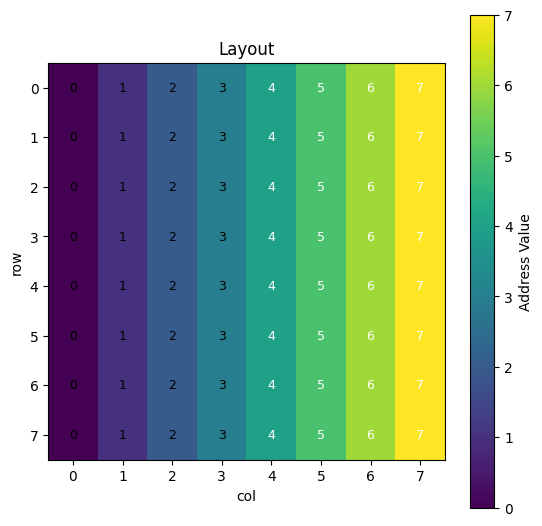

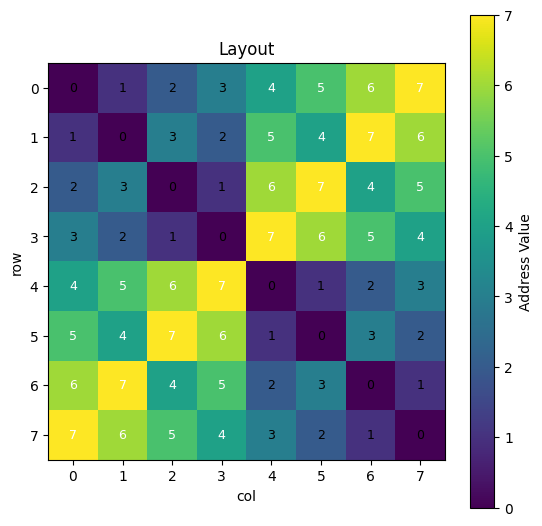

In [336]:
draw_layout(no_swiz_bank)
draw_layout(swiz_bank)

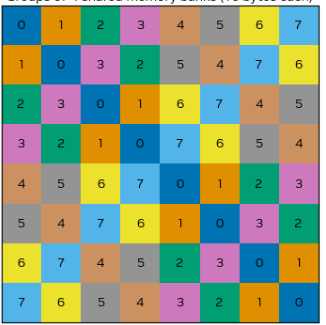

In [337]:
import ast, numpy as np

def load_matrix(path):
    with open(path) as f:
        lines = f.readlines()

    # keep only lines that start with "[" or " "
    array_lines = [ln for ln in lines if "[" in ln or "]" in ln]

    txt = "".join(array_lines)
    return np.array(ast.literal_eval(txt)).astype(int)

A_float_128B = load_matrix("f32_128B_32_32.txt")
print(A_float_128B.shape)


(32, 32)


In [338]:
A_float_128B 

array([[   0,    1,    2, ...,   29,   30,   31],
       [  36,   37,   38, ...,   57,   58,   59],
       [  72,   73,   74, ...,   85,   86,   87],
       ...,
       [ 948,  949,  950, ...,  937,  938,  939],
       [ 984,  985,  986, ...,  965,  966,  967],
       [1020, 1021, 1022, ...,  993,  994,  995]], shape=(32, 32))

In [339]:
layout = Layout((32,32),(32,1), "na")
b_bits = 3 
m_base = 4
s_shift = 3 
n_bytes_per_elem = 4
n_elems_per_vector = 1 

no_swiz,swiz, no_swiz_bank, swiz_bank = make_swizzle(layout,n_elems_per_vector, n_bytes_per_elem, b_bits, m_base,s_shift)

In [340]:
np.all(swiz == A_float_128B)

np.True_

In [341]:
A_bf16_128 = load_matrix("bf16_128B_64_64.txt")

In [342]:
layout = Layout((64,64),(64,1), "na")
b_bits = 3 
m_base = 4
s_shift = 3 
n_bytes_per_elem = 2
n_elems_per_vector = 1 
no_swiz,swiz, no_swiz_bank, swiz_bank = make_swizzle(layout,n_elems_per_vector, n_bytes_per_elem, b_bits, m_base,s_shift)

In [343]:
swiz

array([[   0,    1,    2, ...,   61,   62,   63],
       [  72,   73,   74, ...,  117,  118,  119],
       [ 144,  145,  146, ...,  173,  174,  175],
       ...,
       [3944, 3945, 3946, ..., 3925, 3926, 3927],
       [4016, 4017, 4018, ..., 3981, 3982, 3983],
       [4088, 4089, 4090, ..., 4037, 4038, 4039]], shape=(64, 64))

In [344]:
print(swiz == A_bf16_128)
print(swiz[:5, :] == A_bf16_128[:5,:])

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False False False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True

In [345]:
print(255 in swiz)

True


In [346]:
Y = np.where(swiz==255,1,0)

In [347]:
for x in range(64):
  for y in range(64): 
    if swiz[x][y] == 255:
      print(x,y)
      

3 39


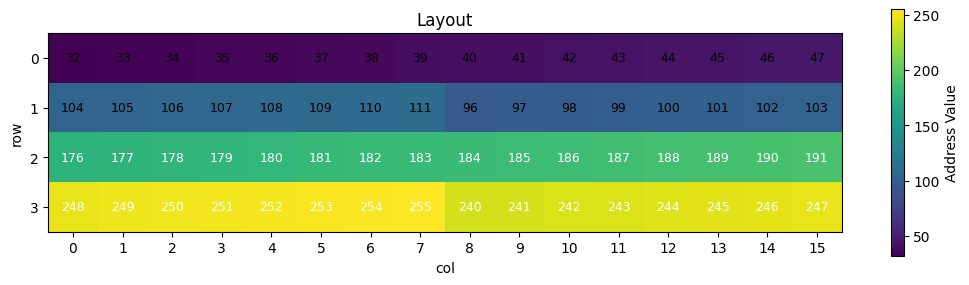

In [348]:
draw_layout(swiz[0:4,32:48])

In [349]:
layout = Layout((16,2),(2,1), "na")
b_bits = 3
m_base = 4
s_shift = 3
n_bytes_per_elem = 2
n_elems_per_vector = 8 
no_swiz,swiz, no_swiz_bank, swiz_bank = make_swizzle(layout,n_elems_per_vector, n_bytes_per_elem, b_bits, m_base,s_shift)

In [350]:
def is_bijection(x): 
  return (np.size(x) == (np.size(np.unique(x)))) and (np.min(x) == 0) and (np.max(x) == np.size(x)-1)

def get_n_conficts(coord_to_addr,coord_to_lane): 
  assert np.size(coord_to_addr) == np.size(coord_to_lane)
  assert coord_to_addr.shape == coord_to_lane.shape 
  assert is_bijection(coord_to_addr) and is_bijection(coord_to_lane)
  conflicts = np.zeros(32).astype(int)
  lane_to_addr = np.zeros(32).astype(int)
  for l in range(32): 
    l_to_coord = np.where(coord_to_lane == l)
    
    coord = tuple([int(x[0].item()) for x in l_to_coord])
    l_to_addr = coord_to_addr[coord]
    lane_to_addr[l] = l_to_addr
    
  return lane_to_addr
    
  

In [351]:
lane = np.arange(32)
matrix = np.zeros((16,2)).astype(int)
for l in lane: 
  row = l % 16 
  col = l // 16
  matrix[row][col] = l 

In [352]:
lane_to_addr = get_n_conficts(no_swiz, matrix)

In [353]:
print(lane_to_addr)

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30  1  3  5  7  9 11 13 15
 17 19 21 23 25 27 29 31]


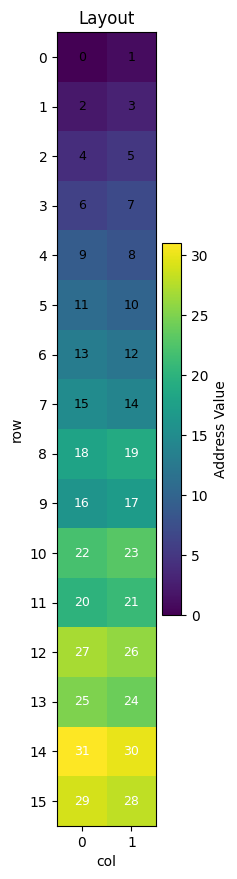

In [354]:
draw_layout(swiz)

In [355]:
out = np.zeros((16,2), dtype=int)

for y in range(16):

    # row-pair swap only in top half
    y2 = y ^ ((y >> 3) & 1)

    # column swap in blocks where bit2 is set
    swap = (y >> 2) & 1

    for x in range(2):
        out[y, x] = no_swiz[y2,x^swap]

print(out)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 9  8]
 [11 10]
 [13 12]
 [15 14]
 [18 19]
 [16 17]
 [22 23]
 [20 21]
 [27 26]
 [25 24]
 [31 30]
 [29 28]]


In [356]:
print(swiz)
print(out == swiz)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 9  8]
 [11 10]
 [13 12]
 [15 14]
 [18 19]
 [16 17]
 [22 23]
 [20 21]
 [27 26]
 [25 24]
 [31 30]
 [29 28]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


In [357]:

for y in range(16):

    # top-half indicator (0 for y<8, 1 for y>=8)
    top = (y // 8) % 2

    # flip within each row-pair if top==1
    y2 = y + top * (1 - 2*(y % 2))

    # swap columns in blocks of 4 rows
    swap = (y // 4) % 2

    for x in range(2):
        x2 = (x + swap) % 2
        out[y, x2] = 2*y2 + x

print(out)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 9  8]
 [11 10]
 [13 12]
 [15 14]
 [18 19]
 [16 17]
 [22 23]
 [20 21]
 [27 26]
 [25 24]
 [31 30]
 [29 28]]


In [358]:
A_32B_bf16_16_16 = load_matrix("bf16_32B_16_16.txt")

In [359]:
print(A_32B_bf16_16_16)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15]
 [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31]
 [ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63]
 [ 72  73  74  75  76  77  78  79  64  65  66  67  68  69  70  71]
 [ 88  89  90  91  92  93  94  95  80  81  82  83  84  85  86  87]
 [104 105 106 107 108 109 110 111  96  97  98  99 100 101 102 103]
 [120 121 122 123 124 125 126 127 112 113 114 115 116 117 118 119]
 [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
 [144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
 [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175]
 [176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191]
 [200 201 202 203 204 205 206 207 192 193 194 195 196 197 198 199]
 [216 217 218 219 220 221 222 223 208 209 210 211 212 213 214 215]
 [232 233 234 235 236 237 238 239 224 225 226 227 228 229 230 

In [374]:


def do_swizzle_and_check(b_bits,m_base,s_shift,A,n_bytes_per_elem=1,n_elems_per_vector=2):
  layout = Layout((16,16),(16,1), "na")
  no_swiz,swiz, no_swiz_bank, swiz_bank = make_swizzle(layout,n_elems_per_vector, n_bytes_per_elem, b_bits, m_base,s_shift)
  if np.all(swiz == A):
    return True, b_bits,m_base,s_shift
  else:
    return False,False,False,False
  
  
  

In [377]:
for b_bits in range(20): 
  for m_base in range(20): 
    for s_shift in range(-20,20): 
      if abs(s_shift) >=b_bits:
        Truth,b_bits,m_base,s_shift = do_swizzle_and_check(b_bits,m_base,s_shift,A_32B_bf16_16_16)
        if Truth:
          print(b_bits,m_base,s_shift)
          break